In [1]:
%reload_ext autoreload
%autoreload 2

import os
import pickle
import logging
import multiprocessing
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp

import arviz as az
import numpyro
import numpyro.distributions as dist

from hbmep.config import Config
from hbmep.model import Baseline
from hbmep.model.utils import Site as site

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()

logger = logging.getLogger(__name__)


In [2]:
class ReLU(Baseline):
    LINK = "RectifiedLinearUnit"

    def __init__(self, config: Config):
        super(ReLU, self).__init__(config=config)
        self.combination_columns = self.features + [self.subject]

    def _model(self, subject, features, intensity, response_obs=None):
        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)

        n_data = intensity.shape[0]
        n_subject = np.unique(subject).shape[0]
        n_feature0 = np.unique(feature0).shape[0]

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            global_sigma_b = numpyro.sample("global_sigma_b", dist.HalfNormal(100))

            global_sigma_L = numpyro.sample("global_sigma_L", dist.HalfNormal(1))

            global_sigma_g_1 = numpyro.sample("global_sigma_g_1", dist.HalfNormal(100))
            global_sigma_g_2 = numpyro.sample("global_sigma_g_2", dist.HalfNormal(100))

            global_sigma_p = numpyro.sample("global_sigma_p", dist.HalfNormal(100))

            with numpyro.plate("n_feature0", n_feature0, dim=-2):
                """ Hyper-priors """
                mu_a = numpyro.sample(site.mu_a, dist.HalfNormal(scale=5))
                sigma_a = numpyro.sample(site.sigma_a, dist.HalfNormal(scale=1))

                sigma_b_raw = numpyro.sample("sigma_b_raw", dist.HalfNormal(scale=1))
                sigma_b = numpyro.deterministic(site.sigma_b, global_sigma_b * sigma_b_raw)

                sigma_L_raw = numpyro.sample("sigma_L_raw", dist.HalfNormal(scale=1))
                sigma_L = numpyro.deterministic(site.sigma_L, global_sigma_L * sigma_L_raw)

                sigma_g_1_raw = numpyro.sample("sigma_g_1_raw", dist.HalfNormal(scale=1))
                sigma_g_1 = numpyro.deterministic("sigma_g_1", global_sigma_g_1 * sigma_g_1_raw)

                sigma_g_2_raw = numpyro.sample("sigma_g_2_raw", dist.HalfNormal(scale=1))
                sigma_g_2 = numpyro.deterministic("sigma_g_2", global_sigma_g_2 * sigma_g_2_raw)

                sigma_p_raw = numpyro.sample("sigma_p_raw", dist.HalfNormal(scale=1))
                sigma_p = numpyro.deterministic("sigma_p", global_sigma_p * sigma_p_raw)

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    """ Priors """
                    a_raw = numpyro.sample("a_raw", dist.Gamma(concentration=mu_a, rate=1))
                    a = numpyro.deterministic(site.a, (1 / sigma_a) * a_raw)

                    b_raw = numpyro.sample("b_raw", dist.HalfNormal(scale=1))
                    b = numpyro.deterministic(site.b, sigma_b * b_raw)

                    L_raw = numpyro.sample("L_raw", dist.HalfNormal(scale=1))
                    L = numpyro.deterministic(site.L, sigma_L * L_raw)

                    g_1_raw = numpyro.sample("g_1_raw", dist.HalfCauchy(scale=1))
                    g_1 = numpyro.deterministic(site.g_1, sigma_g_1 * g_1_raw)

                    g_2_raw = numpyro.sample("g_2_raw", dist.HalfCauchy(scale=1))
                    g_2 = numpyro.deterministic(site.g_2, sigma_g_2 * g_2_raw)

                    p_raw = numpyro.sample("p_raw", dist.HalfNormal(scale=1))
                    p = numpyro.deterministic("p", sigma_p * p_raw)

        """ Model """
        mu = numpyro.deterministic(
            site.mu,
            L[subject, feature0]
            + jnp.where(
                intensity <= a[subject, feature0],
                0,
                b[subject, feature0] * (intensity - a[subject, feature0])
            )
        )
        beta = numpyro.deterministic(
            site.beta,
            g_1[subject, feature0] + g_2[subject, feature0] * ((1 / (mu + 1)) ** p[subject, feature0])
        )

        """ Observation """
        with numpyro.plate(site.data, n_data):
            return numpyro.sample(
                site.obs,
                dist.Gamma(concentration=mu * beta, rate=beta).to_event(1),
                obs=response_obs
            )


In [32]:
class Logistic3(Baseline):
    LINK = "Logistic3"

    def __init__(self, config: Config):
        super(Logistic3, self).__init__(config=config)
        self.combination_columns = self.features + [self.subject]

    def _model(self, subject, features, intensity, response_obs=None):
        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)

        n_data = intensity.shape[0]
        n_subject = np.unique(subject).shape[0]
        n_feature0 = np.unique(feature0).shape[0]

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            global_sigma_b = numpyro.sample("global_sigma_b", dist.HalfNormal(100))

            global_sigma_H = numpyro.sample("global_sigma_H", dist.HalfNormal(5))

            global_sigma_g_1 = numpyro.sample("global_sigma_g_1", dist.HalfNormal(100))
            global_sigma_g_2 = numpyro.sample("global_sigma_g_2", dist.HalfNormal(100))

            global_sigma_p = numpyro.sample("global_sigma_p", dist.HalfNormal(100))

            with numpyro.plate("n_feature0", n_feature0, dim=-2):
                """ Hyper-priors """
                mu_a = numpyro.sample(site.mu_a, dist.HalfNormal(scale=5))
                sigma_a = numpyro.sample(site.sigma_a, dist.HalfNormal(scale=1))

                sigma_b_raw = numpyro.sample("sigma_b_raw", dist.HalfNormal(scale=1))
                sigma_b = numpyro.deterministic(site.sigma_b, global_sigma_b * sigma_b_raw)

                sigma_H_raw = numpyro.sample("sigma_H_raw", dist.HalfNormal(scale=1))
                sigma_H = numpyro.deterministic(site.sigma_H, global_sigma_H * sigma_H_raw)

                sigma_g_1_raw = numpyro.sample("sigma_g_1_raw", dist.HalfNormal(scale=1))
                sigma_g_1 = numpyro.deterministic("sigma_g_1", global_sigma_g_1 * sigma_g_1_raw)

                sigma_g_2_raw = numpyro.sample("sigma_g_2_raw", dist.HalfNormal(scale=1))
                sigma_g_2 = numpyro.deterministic("sigma_g_2", global_sigma_g_2 * sigma_g_2_raw)

                sigma_p_raw = numpyro.sample("sigma_p_raw", dist.HalfNormal(scale=1))
                sigma_p = numpyro.deterministic("sigma_p", global_sigma_p * sigma_p_raw)

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    """ Priors """
                    a_raw = numpyro.sample("a_raw", dist.Gamma(concentration=mu_a, rate=1))
                    a = numpyro.deterministic(site.a, (1 / sigma_a) * a_raw)

                    b_raw = numpyro.sample("b_raw", dist.HalfNormal(scale=1))
                    b = numpyro.deterministic(site.b, sigma_b * b_raw)

                    H_raw = numpyro.sample("H_raw", dist.HalfNormal(scale=1))
                    H = numpyro.deterministic(site.H, sigma_H * H_raw)

                    g_1_raw = numpyro.sample("g_1_raw", dist.HalfCauchy(scale=1))
                    g_1 = numpyro.deterministic(site.g_1, sigma_g_1 * g_1_raw)

                    g_2_raw = numpyro.sample("g_2_raw", dist.HalfCauchy(scale=1))
                    g_2 = numpyro.deterministic(site.g_2, sigma_g_2 * g_2_raw)

                    p_raw = numpyro.sample("p_raw", dist.HalfNormal(scale=1))
                    p = numpyro.deterministic("p", sigma_p * p_raw)

        """ Model """
        mu = numpyro.deterministic(
            site.mu,
            H[subject, feature0]
            / (1 + jnp.exp(-b[subject, feature0] * (intensity - a[subject, feature0])))
        )
        beta = numpyro.deterministic(
            site.beta,
            g_1[subject, feature0] + g_2[subject, feature0] * ((1 / (mu + 1)) ** p[subject, feature0])
        )

        """ Observation """
        with numpyro.plate(site.data, n_data):
            return numpyro.sample(
                site.obs,
                dist.Gamma(concentration=mu * beta, rate=beta).to_event(1),
                obs=response_obs
            )


In [31]:
class Logistic4(Baseline):
    LINK = "Logistic4"

    def __init__(self, config: Config):
        super(Logistic4, self).__init__(config=config)
        self.combination_columns = self.features + [self.subject]

    def _model(self, subject, features, intensity, response_obs=None):
        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)

        n_data = intensity.shape[0]
        n_subject = np.unique(subject).shape[0]
        n_feature0 = np.unique(feature0).shape[0]

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            global_sigma_b = numpyro.sample("global_sigma_b", dist.HalfNormal(100))

            global_sigma_L = numpyro.sample("global_sigma_L", dist.HalfNormal(1))
            global_sigma_H = numpyro.sample("global_sigma_H", dist.HalfNormal(5))

            global_sigma_g_1 = numpyro.sample("global_sigma_g_1", dist.HalfNormal(100))
            global_sigma_g_2 = numpyro.sample("global_sigma_g_2", dist.HalfNormal(100))

            global_sigma_p = numpyro.sample("global_sigma_p", dist.HalfNormal(100))

            with numpyro.plate("n_feature0", n_feature0, dim=-2):
                """ Hyper-priors """
                mu_a = numpyro.sample(site.mu_a, dist.HalfNormal(scale=5))
                sigma_a = numpyro.sample(site.sigma_a, dist.HalfNormal(scale=1))

                sigma_b_raw = numpyro.sample("sigma_b_raw", dist.HalfNormal(scale=1))
                sigma_b = numpyro.deterministic(site.sigma_b, global_sigma_b * sigma_b_raw)

                sigma_L_raw = numpyro.sample("sigma_L_raw", dist.HalfNormal(scale=1))
                sigma_L = numpyro.deterministic(site.sigma_L, global_sigma_L * sigma_L_raw)

                sigma_H_raw = numpyro.sample("sigma_H_raw", dist.HalfNormal(scale=1))
                sigma_H = numpyro.deterministic(site.sigma_H, global_sigma_H * sigma_H_raw)

                sigma_g_1_raw = numpyro.sample("sigma_g_1_raw", dist.HalfNormal(scale=1))
                sigma_g_1 = numpyro.deterministic("sigma_g_1", global_sigma_g_1 * sigma_g_1_raw)

                sigma_g_2_raw = numpyro.sample("sigma_g_2_raw", dist.HalfNormal(scale=1))
                sigma_g_2 = numpyro.deterministic("sigma_g_2", global_sigma_g_2 * sigma_g_2_raw)

                sigma_p_raw = numpyro.sample("sigma_p_raw", dist.HalfNormal(scale=1))
                sigma_p = numpyro.deterministic("sigma_p", global_sigma_p * sigma_p_raw)

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    """ Priors """
                    a_raw = numpyro.sample("a_raw", dist.Gamma(concentration=mu_a, rate=1))
                    a = numpyro.deterministic(site.a, (1 / sigma_a) * a_raw)

                    b_raw = numpyro.sample("b_raw", dist.HalfNormal(scale=1))
                    b = numpyro.deterministic(site.b, sigma_b * b_raw)

                    L_raw = numpyro.sample("L_raw", dist.HalfNormal(scale=1))
                    L = numpyro.deterministic(site.L, sigma_L * L_raw)

                    H_raw = numpyro.sample("H_raw", dist.HalfNormal(scale=1))
                    H = numpyro.deterministic(site.H, sigma_H * H_raw)

                    g_1_raw = numpyro.sample("g_1_raw", dist.HalfCauchy(scale=1))
                    g_1 = numpyro.deterministic(site.g_1, sigma_g_1 * g_1_raw)

                    g_2_raw = numpyro.sample("g_2_raw", dist.HalfCauchy(scale=1))
                    g_2 = numpyro.deterministic(site.g_2, sigma_g_2 * g_2_raw)

                    p_raw = numpyro.sample("p_raw", dist.HalfNormal(scale=1))
                    p = numpyro.deterministic("p", sigma_p * p_raw)

        """ Model """
        mu = numpyro.deterministic(
            site.mu,
            L[subject, feature0]
            + (
                H[subject, feature0]
                / (1 + jnp.exp(-b[subject, feature0] * (intensity - a[subject, feature0])))
            )
        )
        beta = numpyro.deterministic(
            site.beta,
            g_1[subject, feature0] + g_2[subject, feature0] * ((1 / (mu + 1)) ** p[subject, feature0])
        )

        """ Observation """
        with numpyro.plate(site.data, n_data):
            return numpyro.sample(
                site.obs,
                dist.Gamma(concentration=mu * beta, rate=beta).to_event(1),
                obs=response_obs
            )


In [3]:
class Logistic5(Baseline):
    LINK = "Logistic5"

    def __init__(self, config: Config):
        super(Logistic5, self).__init__(config=config)
        self.combination_columns = self.features + [self.subject]

    def _model(self, subject, features, intensity, response_obs=None):
        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)

        n_data = intensity.shape[0]
        n_subject = np.unique(subject).shape[0]
        n_feature0 = np.unique(feature0).shape[0]

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            global_sigma_b = numpyro.sample("global_sigma_b", dist.HalfNormal(100))
            global_sigma_v = numpyro.sample("global_sigma_v", dist.HalfNormal(100))

            global_sigma_L = numpyro.sample("global_sigma_L", dist.HalfNormal(1))
            global_sigma_H = numpyro.sample("global_sigma_H", dist.HalfNormal(5))

            global_sigma_g_1 = numpyro.sample("global_sigma_g_1", dist.HalfNormal(100))
            global_sigma_g_2 = numpyro.sample("global_sigma_g_2", dist.HalfNormal(100))

            global_sigma_p = numpyro.sample("global_sigma_p", dist.HalfNormal(100))

            with numpyro.plate("n_feature0", n_feature0, dim=-2):
                """ Hyper-priors """
                mu_a = numpyro.sample(site.mu_a, dist.HalfNormal(scale=5))
                sigma_a = numpyro.sample(site.sigma_a, dist.HalfNormal(scale=1))

                sigma_b_raw = numpyro.sample("sigma_b_raw", dist.HalfNormal(scale=1))
                sigma_b = numpyro.deterministic(site.sigma_b, global_sigma_b * sigma_b_raw)

                sigma_v_raw = numpyro.sample("sigma_v_raw", dist.HalfNormal(scale=1))
                sigma_v = numpyro.deterministic(site.sigma_v, global_sigma_v * sigma_v_raw)

                sigma_L_raw = numpyro.sample("sigma_L_raw", dist.HalfNormal(scale=1))
                sigma_L = numpyro.deterministic(site.sigma_L, global_sigma_L * sigma_L_raw)

                sigma_H_raw = numpyro.sample("sigma_H_raw", dist.HalfNormal(scale=1))
                sigma_H = numpyro.deterministic(site.sigma_H, global_sigma_H * sigma_H_raw)

                sigma_g_1_raw = numpyro.sample("sigma_g_1_raw", dist.HalfNormal(scale=1))
                sigma_g_1 = numpyro.deterministic("sigma_g_1", global_sigma_g_1 * sigma_g_1_raw)

                sigma_g_2_raw = numpyro.sample("sigma_g_2_raw", dist.HalfNormal(scale=1))
                sigma_g_2 = numpyro.deterministic("sigma_g_2", global_sigma_g_2 * sigma_g_2_raw)

                sigma_p_raw = numpyro.sample("sigma_p_raw", dist.HalfNormal(scale=1))
                sigma_p = numpyro.deterministic("sigma_p", global_sigma_p * sigma_p_raw)

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    """ Priors """
                    a_raw = numpyro.sample("a_raw", dist.Gamma(concentration=mu_a, rate=1))
                    a = numpyro.deterministic(site.a, (1 / sigma_a) * a_raw)

                    b_raw = numpyro.sample("b_raw", dist.HalfNormal(scale=1))
                    b = numpyro.deterministic(site.b, sigma_b * b_raw)

                    v_raw = numpyro.sample("v_raw", dist.HalfNormal(scale=1))
                    v = numpyro.deterministic(site.v, sigma_v * v_raw)

                    L_raw = numpyro.sample("L_raw", dist.HalfNormal(scale=1))
                    L = numpyro.deterministic(site.L, sigma_L * L_raw)

                    H_raw = numpyro.sample("H_raw", dist.HalfNormal(scale=1))
                    H = numpyro.deterministic(site.H, sigma_H * H_raw)

                    g_1_raw = numpyro.sample("g_1_raw", dist.HalfCauchy(scale=1))
                    g_1 = numpyro.deterministic(site.g_1, sigma_g_1 * g_1_raw)

                    g_2_raw = numpyro.sample("g_2_raw", dist.HalfCauchy(scale=1))
                    g_2 = numpyro.deterministic(site.g_2, sigma_g_2 * g_2_raw)

                    p_raw = numpyro.sample("p_raw", dist.HalfNormal(scale=1))
                    p = numpyro.deterministic("p", sigma_p * p_raw)

        """ Model """
        mu = numpyro.deterministic(
            site.mu,
            L[subject, feature0]
            + (
                H[subject, feature0]
                / jnp.power(
                    1 + v[subject, feature0] * jnp.exp(-b[subject, feature0] * (intensity - a[subject, feature0])),
                    1 / v[subject, feature0]
                )
            )
        )
        beta = numpyro.deterministic(
            site.beta,
            g_1[subject, feature0] + g_2[subject, feature0] * ((1 / (mu + 1)) ** p[subject, feature0])
        )

        """ Observation """
        with numpyro.plate(site.data, n_data):
            return numpyro.sample(
                site.obs,
                dist.Gamma(concentration=mu * beta, rate=beta).to_event(1),
                obs=response_obs
            )


In [4]:
from hbmep_paper.utils.constants import HBM


class RectifiedLogistic(Baseline):
    LINK = HBM

    def __init__(self, config: Config):
        super(RectifiedLogistic, self).__init__(config=config)
        self.combination_columns = self.features + [self.subject]

    def _model(self, subject, features, intensity, response_obs=None):
        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)

        n_data = intensity.shape[0]
        n_subject = np.unique(subject).shape[0]
        n_feature0 = np.unique(feature0).shape[0]

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            global_sigma_b = numpyro.sample("global_sigma_b", dist.HalfNormal(100))
            global_sigma_v = numpyro.sample("global_sigma_v", dist.HalfNormal(100))

            global_sigma_L = numpyro.sample("global_sigma_L", dist.HalfNormal(1))
            global_sigma_l = numpyro.sample("global_sigma_l", dist.HalfNormal(100))
            global_sigma_H = numpyro.sample("global_sigma_H", dist.HalfNormal(5))

            global_sigma_g_1 = numpyro.sample("global_sigma_g_1", dist.HalfNormal(100))
            global_sigma_g_2 = numpyro.sample("global_sigma_g_2", dist.HalfNormal(100))

            global_sigma_p = numpyro.sample("global_sigma_p", dist.HalfNormal(100))

            with numpyro.plate("n_feature0", n_feature0, dim=-2):
                """ Hyper-priors """
                mu_a = numpyro.sample(site.mu_a, dist.HalfNormal(scale=5))
                sigma_a = numpyro.sample(site.sigma_a, dist.HalfNormal(scale=1))

                sigma_b_raw = numpyro.sample("sigma_b_raw", dist.HalfNormal(scale=1))
                sigma_b = numpyro.deterministic(site.sigma_b, global_sigma_b * sigma_b_raw)

                sigma_v_raw = numpyro.sample("sigma_v_raw", dist.HalfNormal(scale=1))
                sigma_v = numpyro.deterministic(site.sigma_v, global_sigma_v * sigma_v_raw)

                sigma_L_raw = numpyro.sample("sigma_L_raw", dist.HalfNormal(scale=1))
                sigma_L = numpyro.deterministic(site.sigma_L, global_sigma_L * sigma_L_raw)

                sigma_l_raw = numpyro.sample("sigma_l_raw", dist.HalfNormal(scale=1))
                sigma_l = numpyro.deterministic("sigma_l", global_sigma_l * sigma_l_raw)

                sigma_H_raw = numpyro.sample("sigma_H_raw", dist.HalfNormal(scale=1))
                sigma_H = numpyro.deterministic(site.sigma_H, global_sigma_H * sigma_H_raw)

                sigma_g_1_raw = numpyro.sample("sigma_g_1_raw", dist.HalfNormal(scale=1))
                sigma_g_1 = numpyro.deterministic("sigma_g_1", global_sigma_g_1 * sigma_g_1_raw)

                sigma_g_2_raw = numpyro.sample("sigma_g_2_raw", dist.HalfNormal(scale=1))
                sigma_g_2 = numpyro.deterministic("sigma_g_2", global_sigma_g_2 * sigma_g_2_raw)

                sigma_p_raw = numpyro.sample("sigma_p_raw", dist.HalfNormal(scale=1))
                sigma_p = numpyro.deterministic("sigma_p", global_sigma_p * sigma_p_raw)

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    """ Priors """
                    a_raw = numpyro.sample("a_raw", dist.Gamma(concentration=mu_a, rate=1))
                    a = numpyro.deterministic(site.a, (1 / sigma_a) * a_raw)

                    b_raw = numpyro.sample("b_raw", dist.HalfNormal(scale=1))
                    b = numpyro.deterministic(site.b, sigma_b * b_raw)

                    v_raw = numpyro.sample("v_raw", dist.HalfNormal(scale=1))
                    v = numpyro.deterministic(site.v, sigma_v * v_raw)

                    L_raw = numpyro.sample("L_raw", dist.HalfNormal(scale=1))
                    L = numpyro.deterministic(site.L, sigma_L * L_raw)

                    l_raw = numpyro.sample("l_raw", dist.HalfNormal(scale=1))
                    l = numpyro.deterministic("l", sigma_l * l_raw)

                    H_raw = numpyro.sample("H_raw", dist.HalfNormal(scale=1))
                    H = numpyro.deterministic(site.H, sigma_H * H_raw)

                    g_1_raw = numpyro.sample("g_1_raw", dist.HalfCauchy(scale=1))
                    g_1 = numpyro.deterministic(site.g_1, sigma_g_1 * g_1_raw)

                    g_2_raw = numpyro.sample("g_2_raw", dist.HalfCauchy(scale=1))
                    g_2 = numpyro.deterministic(site.g_2, sigma_g_2 * g_2_raw)

                    p_raw = numpyro.sample("p_raw", dist.HalfNormal(scale=1))
                    p = numpyro.deterministic("p", sigma_p * p_raw)

        """ Model """
        mu = numpyro.deterministic(
            site.mu,
            L[subject, feature0]
            + jnp.where(
                intensity <= a[subject, feature0],
                0,
                -l[subject, feature0]
                + (
                    (H[subject, feature0] + l[subject, feature0])
                    / jnp.power(
                        1
                        + (
                            (
                                -1
                                + jnp.power(
                                    (H[subject, feature0] + l[subject, feature0]) / l[subject, feature0],
                                    v[subject, feature0]
                                )
                            )
                            * jnp.exp(-b[subject, feature0] * (intensity - a[subject, feature0]))
                        ),
                        1 / v[subject, feature0]
                    )
                )
            )
        )
        beta = numpyro.deterministic(
            site.beta,
            g_1[subject, feature0] + g_2[subject, feature0] * ((1 / (mu + 1)) ** p[subject, feature0])
        )

        """ Observation """
        with numpyro.plate(site.data, n_data):
            return numpyro.sample(
                site.obs,
                dist.Gamma(concentration=mu * beta, rate=beta).to_event(1),
                obs=response_obs
            )


In [5]:
dir = "/home/vishu/repos/hbmep-paper/reports/paper/tms"

In [6]:
model_dir = "ReLU"
src = os.path.join(dir, model_dir, "inference.pkl")

with open(src, "rb") as g:
    model_ReLU, mcmc_ReLU, posterior_samples_ReLU = pickle.load(g)


In [33]:
model_dir = "Logistic4"
src = os.path.join(dir, model_dir, "inference.pkl")

with open(src, "rb") as g:
    model_Logistic4, mcmc_Logistic4, posterior_samples_Logistic4 = pickle.load(g)


In [7]:
model_dir = "Logistic5"
src = os.path.join(dir, model_dir, "inference.pkl")

with open(src, "rb") as g:
    model_Logistic5, mcmc_Logistic5, posterior_samples_Logistic5 = pickle.load(g)


In [8]:
model_dir = "RectifiedLogistic"
src = os.path.join(dir, model_dir, "inference.pkl")

with open(src, "rb") as g:
    model_RectifiedLogistic, mcmc_RectifiedLogistic, posterior_samples_RectifiedLogistic = pickle.load(g)


In [9]:
az_data_ReLU = az.from_numpyro(mcmc_ReLU)
az_data_Logistic5 = az.from_numpyro(mcmc_Logistic5)
az_data_Logistic4 = az.from_numpyro(mcmc_Logistic4)
az_data_RectifiedLogistic = az.from_numpyro(mcmc_RectifiedLogistic)


In [35]:
model_dict = {
    "ReLU": az_data_ReLU,
    "Logistic4": az_data_Logistic4,
    "Logistic5": az_data_Logistic5,
    "RectifiedLogistic": az_data_RectifiedLogistic
}


In [36]:
compare_df = az.compare(model_dict)
compare_df


/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the 

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
RectifiedLogistic,0,9015.843779,327.948730,0.000000,3.852363e-01,207.895709,0.000000,True,log
Logistic5,1,9004.303484,328.778886,11.540294,4.426872e-01,209.008319,15.128187,True,log
Logistic4,2,8949.277686,342.206335,66.566092,3.268448e-18,208.516834,19.672495,True,log
ReLU,3,8905.488833,274.573422,110.354946,1.720765e-01,213.246428,24.941661,True,log


Text(0, 0.5, '')

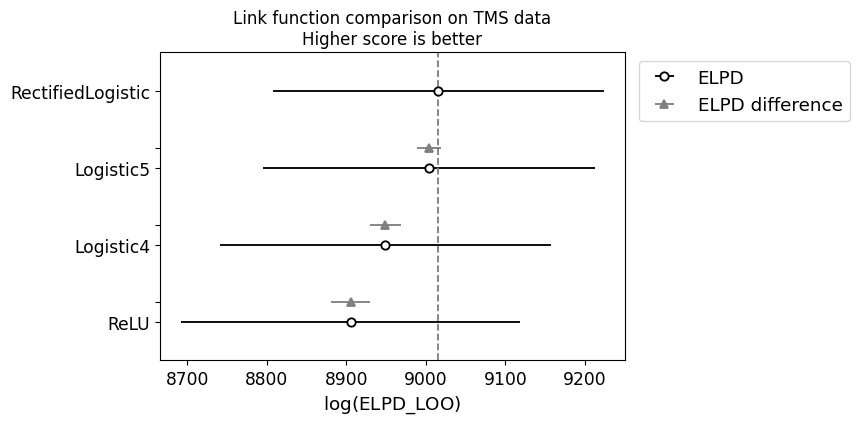

In [37]:
az.plot_compare(comp_df=compare_df)
plt.title("Link function comparison on TMS data\nHigher score is better")
plt.xlabel("$\log($ELPD_LOO$)$")
plt.ylabel("")
